In [4]:
import torch
import torchvision
from model.chatglm1_MMD import *
from model.chatglm2_MMD import *
from model.chatglm1_MPD import *
import pandas as pd
import json
import time
import faiss
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from Dataloder import *
# from chains.local_doc_qa import LocalDocQA
from langchain.docstore.document import Document
from langchain.vectorstores import FAISS
from langchain.docstore.base import AddableMixin, Docstore
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score,precision_recall_curve
# langchain.vectorstores.faiss
#加载全部数据库
# vector_data = read_json_file("/mnt/workspace/pangtianqi/medical_kb_chatbot/data/dataset1.json")
# vector_dataset = MyDataset(vector_data)
# vector_dataloader = torch.utils.data.DataLoader(vector_dataset, batch_size=1, shuffle=False)
#加载测试数据库
raw_data = read_json_file("/mnt/workspace/pangtianqi/medical_kb_chatbot/train/dataset2_test.json")
testing_dataset = MyDataset(raw_data)
testing_dataloader = torch.utils.data.DataLoader(testing_dataset, batch_size=1, shuffle=False)

In [2]:
print(len(raw_data))

573


In [3]:
#test_data = read_json_file("/mnt/workspace/pangtianqi/medical_kb_chatbot/train/test_finetune.json")

In [6]:
#加载模型chatglm1
model =  MyGLU(hidden_size = 768)
device = model.device
# model.load_state_dict(torch.load("model/best_m3e_chatglm1_finetune_L2.ph"))#
# model.load_state_dict(torch.load("/mnt/workspace/pangtianqi/medical_kb_chatbot/train/model/best_m3e_chatglm1_finetune_L2_v1.1.ph"))
# model.load_state_dict(torch.load("model/best_m3e_chatglm1_finetune_v2.ph"))
model = model.to(device)
# print(model)
# print(model)
encoder = model.embed_model
dim =768

Embedding size: 768


In [5]:
# #加载模型chatglm2
# config = ChatGLMConfig()
# model = MyMLP(config)
# device = model.device
# model.load_state_dict(torch.load("model/best_m3e_chatglm2_finetune_L2.ph"))

# model = model.to(device)
# print(model)
# # print(model)
# encoder = model.embed_model
# dim =768

In [6]:
# from sentence_transformers import SentenceTransformer
# encoder = SentenceTransformer('/mnt/workspace/pangtianqi/medical_kb_chatbot/moka-ai/m3e-base', device='cuda:0')

In [8]:
#labels_recall ->所有label存在一个列表
#labels ->按照问题划分的label列表
testing_text = []
labels_list = []
labels_list_recall = []
for batch_data in testing_dataloader:
    # data = batch_data[1][0]
    data,label = batch_data[2:]
    for idx in data:
        for content in idx:
            testing_text.append(content)
    labels_list_recall.append(label)
    for i in label:
        labels_list.append(i)
    # print(labels_list)
labels_recall = [torch.cat(tensor).tolist() for tensor in labels_list_recall]
labels = [tensor.item() for tensor in labels_list]
print("testing_text",len(testing_text))
print("label_recall",len(labels_recall))

testing_text 13990
label_recall 169


In [9]:
#baseline: embedding vector_store
#index ->baseline的索引
content_list = []
for batch_data in testing_text:
    # data, label = batch_data[2:]
    content_vectors = encoder.encode(batch_data)
    content_list.append(content_vectors)

vectors = np.array(content_list,dtype=np.float32)
# augmented_vectors = np.flip(vectors, axis=1)
# vectors = np.ascontiguousarray(vectors)
# augmented_vectors = np.ascontiguousarray(augmented_vectors)
# combined_vectors = np.concatenate((vectors, augmented_vectors), axis=1,dtype=np.float32)
# print("原始数据形状:", vectors.shape)
# print("增强后的数据形状:", augmented_vectors.shape)
# print("拼接后的数据形状:", combined_vectors.shape)
# print("vectors",len(vectors))
# 选择faiss index
faiss.normalize_L2(vectors)
index = faiss.IndexFlatIP(dim)
# 数据插入
# 训练索引获取重构能力
index.train(vectors)
index.add(vectors)

In [10]:
#model: embedding vector_store
#index_ -> model的索引
content_list_ = []
for batch_data in testing_text:
    # data, label = batch_data[2:]
    content_vectors_ = model(batch_data)
    content_vectors_ = content_vectors_.cpu()
    content_vectors_ = content_vectors_.detach().numpy()
    content_list_.append(content_vectors_)

vectors_ = np.array(content_list_,dtype=np.float32)
print("vectors_",vectors_.shape)

# 选择faiss index
faiss.normalize_L2(vectors_)


index_ = faiss.IndexFlatIP(dim)

# 数据插入
# 训练索引获取重构能力
index_.train(vectors_)
index_.add(vectors_)

vectors_ (13990, 768)


In [18]:
#baseline -> 计算准确率，召回率、精度
k = [2,4,6,8,10,20,30]
for top_k in k:
    print("top_k",top_k)
    count= 0
    precision_all, recall_all, accuracy_all = 0, 0, 0
    start_time = time.time()
    label_pair = []
    D_pair = []
    score_pair = []
    text_list = []
    query_list = []
    len_query = len(testing_dataloader)
    hit_count = 0
    for batch_data in testing_dataloader:
        count_1 = 0
        tp, fp, fn, tn = 0, 0, 0, 0
        query = batch_data[1][0]
        # print("query",query)
        # query_list.append(query)
        # data = batch_data[1]
        data,label = batch_data[2:]
        # print(len(data))
        query_feat = np.array([encoder.encode(query)]) # 得到baseline query embed
        faiss.normalize_L2(query_feat)
        print("hello")
        D, I= index.search(query_feat, top_k) #提取出ours的topk
        #print('scores_, indices_',D_, I_[0])
        
        D_pair.append(D)
        for value in label:
            if value == 1:
                count_1 += 1 #这个q对应的回答中所有label为1的个数
        #print("count_1",count_1)
        # for text in I_[0]:
            # text_list.append(testing_text[text])
            #print("content",testing_text[text])
        for i in I[0]:
            #print("labels[i]",labels[i])
            label_pair.append(labels[i])
        # lst = [] # 模型召回的
        
        # count_0 = len(label[0])
        for i in I[0]:
            if labels[i] == 1:
                tp = tp+1
            # elif labels[i] == 0: # 若labels=1的在模型中的label也等于１
            #     break
        #print("tp",tp)
        #print(len(label))
        if top_k < len(label):
            fp = top_k-tp
        else:
            fp = len(label)-tp
        #print("fp",fp)
        fn = count_1-tp
        #print("fn",fn)
        count_0 = len(labels)-count_1
        tn = count_0-fp
        
        if count_1!=0 : #排除label全为1或全为0的情况
            count+=1
            precision = float(tp/(tp+fp))
            if tp >= count_1:
                recall = 1.0
            else:
                recall = float(tp/(tp+fn))
            accuracy = float((tp+tn)/(tp+fp+tn+fn))

            precision_all += precision
            recall_all += recall
            accuracy_all += accuracy
        if tp!= 0:
            hit_count +=1
        # if count_1 == 0:
        #     len_query -= 1
    print("hit_count",hit_count)
    print("len_query",len_query)
    for item in D_pair:
        for score in item:
            score_pair.extend(score)
    # print("score_pair",len(score_pair_))
    # print("label_pair",len(label_pair_))
    print(f"top_{top_k},recall_ave_m3e: {float(recall_all/count)}")
    print(f"top_{top_k},precision_ave_m3e: {float(precision_all/count)}")
    mAP = average_precision_score(label_pair, score_pair, average='macro')
    print(f"top_{top_k},mAP_m3e:", mAP)
    #print(f"accuracy_ave_m3e: {float(accuracy_all/count)}")
    print(f"top_{top_k},hit_rate_ave_m3e:{float(hit_count/len_query)}")
    end_time = time.time()
    elapsed_time = end_time - start_time
    # print("text_list",text_list)
    print(f"Time spent: {elapsed_time:.5f} seconds")

top_k 2
hello


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_65720/2137758654.py:27 in <module>                                                │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_65720/2137758654.py'                        │
│                                                                                                  │
│ /home/pai/envs/kb_chat/lib/python3.9/site-packages/faiss/class_wrappers.py:327 in                │
│ replacement_search                                                                               │
│                                                                                                  │
│   324 │   │   │   When not enough results are found, the label is set to -1                      │
│   325 │   │   """                                                                                │
│   326 │   │                                                                                      │
│ ❱ 327 │   │   n, d = x.shape                                                                     │
│   328 │   │   x = np.ascontiguousarray(x, dtype='float32')                                       │
│   329 │   │   assert d == self.d                                                                 │
│   330                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: too many values to unpack (expected 2)

precision 0.5521994453807261
recall 0.5641452259315843
thresholds 0.8423093608612023
mAP_glm1: 0.5706055080211958


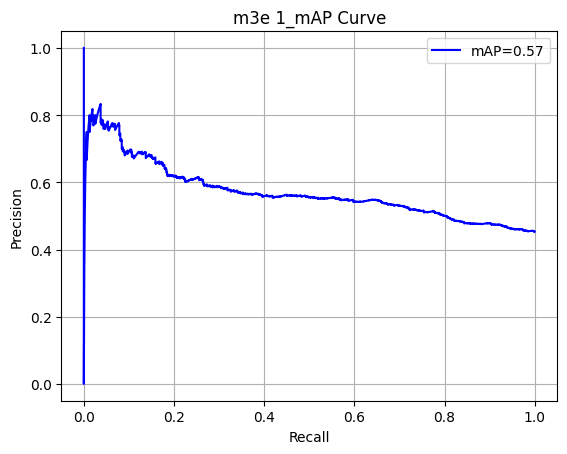

In [11]:
#baseline ->计算mAP

import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score,precision_recall_curve
length = len(label_pair)
# 计算不同阈值下的精确率和召回率
precision, recall, thresholds = precision_recall_curve(label_pair, score_pair)
print("precision",sum(precision)/length)
print("recall",sum(recall)/length)
print("thresholds",sum(thresholds)/length)
# 计算每个阈值下的平均精度均值
# average_precision = average_precision_score(true_labels, predicted_probs)
mAP = average_precision_score(label_pair, score_pair, average='macro')
print("mAP_glm1:", mAP)

# 绘制曲线图
plt.plot(recall, precision, color='b', label=f'mAP={mAP:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('m3e 1_mAP Curve')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [12]:
top_k = 6
# text_list = []
result_m3e = {}  # 创建空字典    
for i,batch_data in enumerate(testing_dataloader):
     query = batch_data[1][0]
     query_feat = np.array([encoder.encode(query)])
     # query_feat_ = model(query) # 得到model query embed
     # query_feat_ = query_feat_.cpu()
     # query_feat_ = np.array([query_feat_.detach()])
     faiss.normalize_L2(query_feat)
     D, I= index.search(query_feat, top_k) 
     text_list = []
     for text in I[0]:
          text_list.append(testing_text[text])
     # print(text_list)
          # content = testing_text[text]
     result_m3e[i] = {
          "query": query,
          "content": text_list,
          "score": D
     }  
     result_m3e[i]['score'] = result_m3e[i]['score'].tolist()
# print(result_m3e)

In [13]:
import json
# result[0]['score'] = result[0]['score'].tolist()
# print(result)
# 将字典转换为 JSON 字符串
json_data_ = json.dumps(result_m3e,ensure_ascii=False)

# 将 JSON 字符串保存到本地文件
file_path = "result_m3e.json"
with open(file_path, "w", encoding="utf-8") as file:
    file.write(json_data_)

In [14]:
#model -> 计算准确率，召回率、精度
k = [2,4,6,8,10,20,30]
for top_k in k:
    print("top_k",top_k)
    count= 0
    precision_all, recall_all, accuracy_all = 0, 0, 0
    start_time = time.time()
    label_pair_ = []
    D_pair_ = []
    score_pair_ = []
    text_list = []
    query_list = []
    len_query = len(testing_dataloader)
    hit_count = 0
    for batch_data in testing_dataloader:
        count_1 = 0
        tp, fp, fn, tn = 0, 0, 0, 0
        query = batch_data[1][0]
        # print("query",query)
        # query_list.append(query)
        data, label = batch_data[2:]
        # print(len(data))
        # query_feat = np.array([encoder.encode(query)]) # 得到baseline query embed
        query_feat_ = model(query) # 得到model query embed
        query_feat_ = query_feat_.cpu()
        query_feat_ = np.array([query_feat_.detach()])
        faiss.normalize_L2(query_feat_)
        D_, I_ = index_.search(query_feat_, top_k) #提取出ours的topk
        #print('scores_, indices_',D_, I_[0])
        D_pair_.append(D_)
        for value in label:
            if value == 1:
                count_1 += 1 #这个q对应的回答中所有label为1的个数
        #print("count_1",count_1)
        for i in I_[0]:
            #print("labels[i]",labels[i])
            label_pair_.append(labels[i])
        # count_0 = len(label[0])
        for i in I_[0]:
            if labels[i] == 1:
                tp = tp+1

        if top_k < len(label):
            fp = top_k-tp
        else:
            fp = len(label)-tp
        #print("fp",fp)
        fn = count_1-tp
        #print("fn",fn)
        count_0 = len(labels)-count_1
        tn = count_0-fp
        if count_1!=0 : #排除label全为1或全为0的情况
            count+=1
            precision = float(tp/(tp+fp))
            accuracy = float((tp+tn)/(tp+fp+tn+fn))
            if tp >= count_1:
                recall = 1.0
            else:
                recall = float(tp/(tp+fn))
            # print("recall",recall)
            precision_all += precision
            recall_all += recall
            accuracy_all += accuracy
        if tp!= 0:
            hit_count +=1
        # if count_1 == 0:
        #     len_query -= 1
    print("hit_count",hit_count)
    print("len_query",len_query)
    for item in D_pair_:
        for score in item:
            score_pair_.extend(score)
    # print("score_pair",len(score_pair_))
    # print("label_pair",len(label_pair_))
    print(f"top_{top_k},recall_ave_model: {float(recall_all/count)}")
    print(f"top_{top_k},precision_ave_model: {float(precision_all/count)}")
    mAP = average_precision_score(label_pair_, score_pair_, average='macro')
    print(f"top_{top_k},mAP_model:", mAP)
    #print(f"accuracy_ave_m3e: {float(accuracy_all/count)}")
    print(f"top_{top_k},hit_rate_ave_model:{float(hit_count/len_query)}")
    end_time = time.time()
    elapsed_time = end_time - start_time
    # print("text_list",text_list)
    print(f"Time spent: {elapsed_time:.5f} seconds")

top_k 2
hit_count 63
len_query 69
top_2,recall_ave_model: 0.11507673462418518
top_2,precision_ave_model: 0.8688524590163934
top_2,mAP_model: 0.888255296703662
top_2,hit_rate_ave_model:0.9130434782608695
Time spent: 5.42974 seconds
top_k 4
hit_count 64
len_query 69
top_4,recall_ave_model: 0.19384490114775882
top_4,precision_ave_model: 0.7991803278688525
top_4,mAP_model: 0.8604714641770211
top_4,hit_rate_ave_model:0.927536231884058
Time spent: 5.41563 seconds
top_k 6
hit_count 66
len_query 69
top_6,recall_ave_model: 0.2688954306783428
top_6,precision_ave_model: 0.7677595628415301
top_6,mAP_model: 0.8322251879103599
top_6,hit_rate_ave_model:0.9565217391304348
Time spent: 5.58595 seconds
top_k 8
hit_count 67
len_query 69
top_8,recall_ave_model: 0.3278533615525358
top_8,precision_ave_model: 0.7295081967213115
top_8,mAP_model: 0.8027406498790406
top_8,hit_rate_ave_model:0.9710144927536232
Time spent: 5.49586 seconds
top_k 10
hit_count 67
len_query 69
top_10,recall_ave_model: 0.39049315047155

In [15]:
import numpy as np

def compute_kl_divergence(p, q):
    kl_divergence = np.sum(p * np.log(p / q))
    return kl_divergence

# 示例：计算两个离散概率分布的KL散度
p = np.array(score_pair)
q = np.array(score_pair_)
print("p",p)
print("q",q)
kl_divergence = compute_kl_divergence(p, q)
print("KL散度:", kl_divergence)

p [0.89475274 0.8846623  0.8818468  ... 0.85639095 0.85586524 0.85569996]
q [0.76717365 0.741063   0.72328603 ... 0.49702394 0.49476162 0.49446967]
KL散度: 1106.9425


precision 0.6444747406587958
recall 0.5729821971730152
thresholds 0.4570740347611155
mAP_glm1: 0.6655227898660769


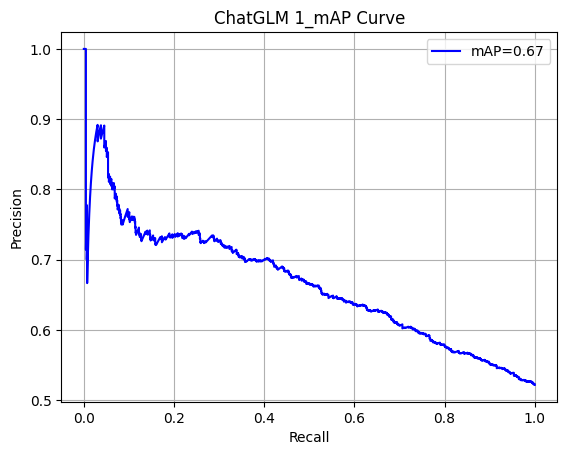

In [16]:
#model ->计算mAP
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score,precision_recall_curve
length = len(label_pair_)
# 计算不同阈值下的精确率和召回率
precision, recall, thresholds = precision_recall_curve(label_pair_, score_pair_)
print("precision",sum(precision)/length)
print("recall",sum(recall)/length)
print("thresholds",sum(thresholds)/length)
# 计算每个阈值下的平均精度均值
# average_precision = average_precision_score(true_labels, predicted_probs)
mAP = average_precision_score(label_pair_, score_pair_, average='macro')
print("mAP_glm1:", mAP)

# 绘制曲线图
plt.plot(recall, precision, color='b', label=f'mAP={mAP:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('ChatGLM 1_mAP Curve')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [17]:
#存储检索结果
top_k = 6
# text_list = []
result = {}  # 创建空字典    
for i,batch_data in enumerate(testing_dataloader):
     query = batch_data[1][0]
     query_feat_ = model(query) # 得到model query embed
     query_feat_ = query_feat_.cpu()
     query_feat_ = np.array([query_feat_.detach()])
     faiss.normalize_L2(query_feat_)
     D_, I_ = index_.search(query_feat_, top_k) 
     text_list = []
     for text in I_[0]:
          text_list.append(testing_text[text])
     # print(text_list)
          # content = testing_text[text]
     result[i] = {
          "query": query,
          "content": text_list,
          "score": D_
     }  
     result[i]['score'] = result[i]['score'].tolist()
# print(result)
     

In [18]:
import json
# 将字典转换为 JSON 字符串
json_data = json.dumps(result,ensure_ascii=False)
# 将 JSON 字符串保存到本地文件
file_path = "result.json"
with open(file_path, "w", encoding="utf-8") as file:
    file.write(json_data)

In [19]:
#单个查询

query = "消化不良能吃乳酶生片吗？"
#乳酶生片
top_k = 10
start_time = time.time()
query_feat = np.array([encoder.encode(query)])   
faiss.normalize_L2(query_feat)
D, I = index.search(query_feat, top_k) 
text_list = []
for text in I[0]:
    # text_list.append(testing_text[text])
    print(testing_text[text])
#print(D)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time spent: {elapsed_time:.2f} seconds")

乳酶生片 - 消化科用药 儿童禁忌 遵医嘱。
乳酶生片 - 消化科用药 孕妇禁忌 遵医嘱。
乳酶生片 - 消化科用药 老年人禁忌 遵医嘱。
乳酶生片 - 消化科用药 禁忌症 尚不明确。
乳酶生片 - 消化科用药 适应症 用于消化不良、腹胀及小儿饮食失调所引起的腹泻、绿便等。
乳酶生 - 助消化药 适应症 用于消化不良、腹胀及小儿饮食失调所引起的腹泻、绿便等。
乳酸菌素片 - 消化科用药 禁忌症 尚不明确。
养胃颗粒 - 消化科用药 用法用量 开水冲服。一次１袋，一日3次。
乳酸菌素片 - 消化科用药 适应症 用于肠内异常发酵、消化不良、肠炎和小儿腹泻。
胃灵颗粒 - 消化科用药 用法用量 开水冲服。一次5克，一日3次。
Time spent: 0.02 seconds


In [20]:
#单个查询蒲地蓝消炎片|蒲地蓝消炎口服液
# query = "急性肠胃炎吃什么药？"
# top_k = 2
start_time = time.time()
query_ = model(query) # 得到model query embed
query_= query_.cpu()
query_ = np.array([query_.detach()])
faiss.normalize_L2(query_)
D_, I_ = index_.search(query_, top_k) 
text_list = []
for text in I_[0]:
    # text_list.append(testing_text[text])
    print(testing_text[text])
# print(D_)
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Time spent: {elapsed_time:.2f} seconds")

乳酶生片 - 消化科用药 儿童禁忌 遵医嘱。
乳酶生片 - 消化科用药 孕妇禁忌 遵医嘱。
乳酶生片 - 消化科用药 老年人禁忌 遵医嘱。
乳酶生片 - 消化科用药 禁忌症 尚不明确。
胃痛宁片 - 消化科用药 孕妇禁忌 孕妇、哺乳期妇女禁用。
奥美拉唑 - 消化科用药 儿童禁忌 婴幼儿禁用。
胃痛宁片 - 消化科用药 儿童禁忌 儿童禁用。
乳果糖口服溶液 丹康 消化科用药 孕妇禁忌 妊娠期头3个月慎用。
奥美拉唑镁肠溶片 洛赛克MUPS 消化科用药 孕妇禁忌 孕期、哺乳期妇女慎用。
乳酸菌素 - 助消化药 适应症 暂无数据
Time spent: 0.02 seconds
